# Flux with MNIST and GPU


## Libraries

In [1]:
using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();


In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### Model

In [7]:
# data on gpu
X_d = X |> gpu
y_d = y |> gpu;


In [8]:
# model configuration
nInputs  = d
nOutputs = 10

model = Chain( Flux.Dense(nInputs, nOutputs, tanh), softmax ) |> gpu   # weights on gpu

lossFunction(X, y) = Flux.mse( model(X), y )
modelParameters    = Flux.params(model)
data               = Flux.DataLoader((X_d, y_d), batchsize=256)        # default batchsize=1
callBack           = Flux.throttle(() -> println("training"), 10);     # print every 10s


### Train

In [9]:
# custom made function that provides access to loss function outcome
function trainModel!(loss, ps, data, opt)
    dataLosses = Vector{Float32}()
        
    for d in data
        l = loss(d...)
        gs = gradient(ps) do
            loss(d...)
        end
        Flux.update!(opt, ps, gs)
            
        push!(dataLosses, l)
    end
    
    return mean(dataLosses)
end


trainModel! (generic function with 1 method)

In [10]:
numberOfEpochs = 100;

In [11]:
epochs = 1:numberOfEpochs
epochLosses = Vector{Float32}()

for epoch in epochs
    l = trainModel!( lossFunction, modelParameters, data, Flux.Descent() )
    push!(epochLosses, l)
end


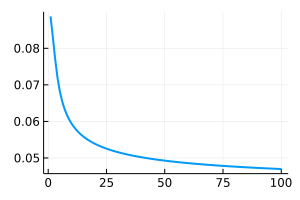

In [12]:
plot(epochs, epochLosses, size=(300,200), linewidth=2, legend=false)

### Predict

In [13]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

ŷ = predictOutcome(X_d)
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 4010     0    33    31     7   119    33    38    45    38
    0  4551    60    29    24    65    18    69   130    30
   12    19  3542   140    25    24    35    56    56    33
   14    20    64  3668     2   186     4    16   151    78
   12     4   101    11  3658    90    30    69    41   169
   10    37     6   150     4  2908    54     6   142    26
   34     9    92    48    53    93  3932     5    42     2
    5    11   105    58    11    32     3  3960    24   164
   45    61   137    95    59   188    32    21  3369    39
    4     7    31    62   246    90     2   146    96  3585

accuracy: 0.885
f1-score: 0.883
